In [18]:
import sys

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

import cv2
from PIL import Image
from torchvision import transforms
from pipelines.video_action_recognition_config import get_cfg_defaults
from models.tuber_ava import build_model
from glob import glob
import json
import datasets.video_transforms as T

# transform = transforms.Compose([
#     transforms.Resize((384, 384)),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225],
#     ),
# ])
def read_label_map(label_map_path):

    item_id = None
    item_name = None
    items = {}
    
    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id:" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "name" in line:
                item_name = line.split(":", 1)[1].replace("'", "").strip()

            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None
            items[81] = "happens"

    return items

items = read_label_map("../assets/ava_action_list_v2.1.pbtxt")

def make_transforms(image_set, cfg):
    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    print("transform image crop: {}".format(cfg.CONFIG.DATA.IMG_SIZE))
    if image_set == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomSizeCrop_Custom(cfg.CONFIG.DATA.IMG_SIZE),
            T.ColorJitter(),
            normalize,
        ])

    if image_set == 'val':
        return T.Compose([
            T.Resize_Custom(cfg.CONFIG.DATA.IMG_SIZE),
            normalize,
        ])

    if image_set == 'visual':
        return T.Compose([
            T.Resize_Custom(cfg.CONFIG.DATA.IMG_SIZE),
            normalize,
        ])
    raise ValueError(f'unknown {image_set}')

cfg = get_cfg_defaults()
cfg.merge_from_file("./configuration/TubeR_CSN152_AVA21.yaml")
model, _, _ = build_model(cfg)

checkpoint = torch.load("../pretrained_models/main/TubeR_CSN152_AVA21.pth")
model_dict = model.state_dict()
pretrained_dict = {k[7:]: v for k, v in checkpoint['model'].items() if k[7:] in model_dict}
unused_dict = {k[:7]: v for k, v in checkpoint['model'].items() if not k[7:] in model_dict}
not_found_dict = {k: v for k, v in model_dict.items() if not "module."+k in checkpoint['model']}
print("# successfully loaded model layers:", len(pretrained_dict.keys()))
print("# unused model layers:", len(unused_dict.keys()))
print("# not found layers:", len(not_found_dict.keys()))
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
transforms=make_transforms("val", cfg)

model.eval()
sample_image1_path = "/mnt/tmp/frames/xeGWXqSvC-8/xeGWXqSvC-8_000360.jpg" #False
sample_image2_path = "/mnt/tmp/frames/CMCPhm2L400/CMCPhm2L400_011200.jpg" #False
sample_image3_path = "/mnt/tmp/frames/Gvp-cj3bmIY/Gvp-cj3bmIY_024750.jpg" #True

# '/home/nsml/assets/ava_{}_v21.json'
val_bbox_json = json.load(open(cfg.CONFIG.DATA.ANNO_PATH.format("val")))
video_frame_bbox = val_bbox_json["video_frame_bbox"]


def load_annotation(sample_id, video_frame_list): # (val 혹은 train의 key frame을 표시해놓은 list)

    num_classes = 80
    boxes, classes = [], []
    target = {}

    first_img = cv2.imread(video_frame_list[0])

    oh = first_img.shape[0]
    ow = first_img.shape[1]
    if oh <= ow:
        nh = 256
        nw = 256 * (ow / oh)
    else:
        nw = 256
        nh = 256 * (oh / ow)

    p_t = int(32 // 2)
    key_pos = p_t

    anno_entity = video_frame_bbox[sample_id]

    for i, bbox in enumerate(anno_entity["bboxes"]):
        label_tmp = np.zeros((num_classes, ))
        acts_p = anno_entity["acts"][i]
        for l in acts_p:
            label_tmp[l] = 1

        if np.sum(label_tmp) == 0: continue
        p_x = np.int_(bbox[0] * nw)
        p_y = np.int_(bbox[1] * nh)
        p_w = np.int_(bbox[2] * nw)
        p_h = np.int_(bbox[3] * nh)

        boxes.append([p_t, p_x, p_y, p_w, p_h])
        classes.append(label_tmp)

    boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 5)
    boxes[:, 1::3].clamp_(min=0, max=int(nw))
    boxes[:, 2::3].clamp_(min=0, max=nh)

    if boxes.shape[0]:
        raw_boxes = F.pad(boxes, (1, 0, 0, 0), value=0)
    else:
        raw_boxes = boxes
    classes = np.array(classes)
    classes = torch.as_tensor(classes, dtype=torch.float32).reshape(-1, num_classes)

    target["image_id"] = [str(sample_id).replace(",", "_"), key_pos]
    target['boxes'] = boxes
    target['raw_boxes'] = raw_boxes
    target["labels"] = classes
    target["orig_size"] = torch.as_tensor([int(nh), int(nw)])
    target["size"] = torch.as_tensor([int(nh), int(nw)])
    # self.index_cnt = self.index_cnt + 1

    return target


def loadvideo(start_img, vid, frame_key):
    frame_path = "/mnt/tmp/frames/{}"
    video_frame_path = frame_path.format(vid)
    video_frame_list = sorted(glob(video_frame_path + '/*.jpg'))

    if len(video_frame_list) == 0:
        print("path doesnt exist", video_frame_path)
        return [], []
    
    target = load_annotation(frame_key, video_frame_list)

    start_img = np.max(start_img, 0)
    end_img = start_img + 32 * 2
    indx_img = list(np.clip(range(start_img, end_img, 2), 0, len(video_frame_list) - 1))
    buffer = []
    for frame_idx in indx_img:
        tmp = Image.open(video_frame_list[frame_idx])
        tmp = tmp.resize((target['orig_size'][1], target['orig_size'][0]))
        buffer.append(tmp)

    return buffer, target
# frame_key is one of "xeGWXqSvC-8,0911", "CMCPhm2L400,1274", "Gvp-cj3bmIY,1725", "Gvp-cj3bmIY_1675"
frame_key = "Gvp-cj3bmIY,1675" 
vid, frame_second = frame_key.split(',')
timef = int(frame_second) - 900
start_img = np.max((timef * 30 - 32 // 2 * 2, 0))

imgs, target = loadvideo(start_img, vid, frame_key)

"""
start_img: start_img number, int
vid: xeGWXqSvC-8, CMCPhm2L400, Gcp-cj3bmIY
frame_key: 0911, 1274, 1725

"""
orig_vid = imgs
imgs, target = transforms(imgs, target)
ho,wo = imgs[0].shape[-2], imgs[0].shape[-1]
imgs = torch.stack(imgs, dim=0)
imgs = imgs.permute(1, 0, 2, 3)

# print(len(imgs), imgs[0].shape, target)

device = "cuda:0"
model = model.to(device)
imgs = imgs.to(device)

# print(attn_weights.shape)

conv_features, enc_attn_weights, dec_attn_weights = [], [], []
input = imgs.unsqueeze(0)

hooks = [
    model.backbone.body.layer4[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]
outputs, attn_weights = model(imgs.unsqueeze(0))

for hook in hooks:
    hook.remove()

conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

num_classes 80
CSN-152 backbone
last stride: 1
build CSN-152, tune point: 4
using refined transformer
# successfully loaded model layers: 1149
# unused model layers: 1
# not found layers: 0
transform image crop: 256


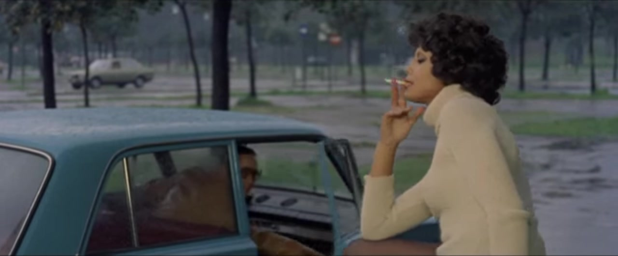

In [19]:
orig_vid[16]

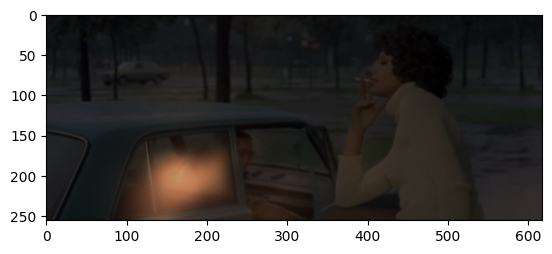

In [20]:
# im=misc.imread("photosAfterAverage/exampleAfterAverage1.jpg")
h, w = conv_features.shape[-2:]
plt.figure()
plt.imshow(orig_vid[16])

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.imshow(dec_attn_weights[0, 2].detach().cpu().view(h, w), cmap='copper', interpolation='bicubic', alpha=.7, extent=(xmin, xmax, ymin, ymax))

# plt.imshow(test.detach().cpu().view(h, w), cmap='copper', interpolation='nearest', alpha=.8, extent=(xmin, xmax, ymin, ymax))
plt.show()

In [21]:
# frame_key is one of "xeGWXqSvC-8,0911", "CMCPhm2L400,1274", "Gvp-cj3bmIY,1725" 
if frame_key == "xeGWXqSvC-8,0911":
    query_logits = [[-0.9729043245315552, 0.19144439697265625, 40.67808532714844, 243.0833740234375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.192487439373508e-05],
    [78.77100372314453, 0.0103607177734375, 340.71826171875, 256.00970458984375, 0.0001033775188261643, 8.965242770386794e-09, 0.00026691073435358703, 3.072612344112713e-06, 7.221223086162354e-08, 5.237266123003792e-06, 2.838251766945632e-08, 8.741355850361288e-05, 4.194988889594242e-07, 1.2679817018579342e-07, 0.8579350113868713, 0.29042816162109375, 4.398419761741934e-08, 0.0005043750861659646, 0.00013599905651062727, 3.6263741094444413e-06, 0.5515451431274414, 6.756181392120197e-06, 5.427819814940449e-06, 1.5260248176218738e-07, 3.5839514112012694e-06, 7.065589215926593e-07, 5.741247514379211e-05, 3.328475941088982e-05, 1.2310040764518249e-09, 1.1568172340048477e-05, 0.13680671155452728, 2.521680471545551e-06, 0.03443540632724762, 2.699221113289241e-07, 1.60155675388296e-08, 4.487760179472389e-06, 8.718334498780678e-08, 2.005489392331583e-07, 1.6505299349489633e-09, 0.00016762113955337554, 0.00014857621863484383, 1.206019760502386e-06, 1.5776824966451386e-06, 2.0231702364981174e-05, 5.59322907065507e-05, 3.15008514917281e-06, 2.6687359877541894e-06, 5.97190819462412e-06, 1.4090309377934318e-05, 9.57088786890381e-07, 0.0007174544152803719, 0.009562344290316105, 3.1679226140113315e-06, 4.94867208544747e-06, 8.95763878361322e-06, 3.025003803003301e-09, 2.7758382398213044e-11, 0.0007247072062455118, 0.0001378928718622774, 6.841546564828604e-07, 4.487928163143806e-05, 1.16959190563648e-05, 0.028124013915657997, 1.3811841199640185e-05, 9.359087562188506e-05, 1.0883383083637455e-06, 0.000290795142063871, 6.888751613587374e-08, 0.00015476078260689974, 3.2868285870790714e-06, 5.231799605098786e-06, 1.8055696671126498e-07, 1.6208128954531276e-06, 8.43532779981615e-06, 1.1751857265096533e-09, 1.8190734408563003e-05, 1.5766747765155742e-06, 0.015401594340801239, 4.933922355121467e-06, 1.8489474840066578e-08, 7.547430868726224e-06, 0.00012301422248128802, 0.009788210503757, 0.009499814361333847, 0.9998612403869629],
    [264.7733459472656, 1.465240478515625, 346.49951171875, 255.157470703125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.116506897844374e-05],
    [328.2110595703125, 34.15913391113281, 341.210205078125, 233.12245178222656, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.785321213304996e-05],
    [104.24423217773438, 2.17388916015625, 218.4002227783203, 148.05624389648438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.74820800870657e-05],
    [36.03322219848633, -12.656265258789062, 160.63746643066406, 198.1731414794922, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.779377144994214e-05],
    [294.5227355957031, 4.778472900390625, 341.174072265625, 146.48361206054688, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001495624746894464],
    [15.497404098510742, 0.57623291015625, 249.00843811035156, 256.5407409667969, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.797867248067632e-05],
    [37.650115966796875, 0.167877197265625, 314.6681823730469, 256.1647033691406, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.1798259189818054e-05],
    [-0.9718995094299316, 3.3333206176757812, 55.77705001831055, 256.02593994140625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0335480510548223e-05],
    [-0.026783034205436707, 5.151969909667969, 4.748565673828125, 258.034423828125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9944667656091042e-05],
    [239.52731323242188, 0.9930877685546875, 349.4954528808594, 255.14988708496094, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4702545488253236e-05],
    [0.008295692503452301, 66.49250030517578, 1.9045642614364624, 242.52499389648438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2500875275e-05],
    [-0.5256537199020386, 1.8598709106445312, 20.668014526367188, 256.7052307128906, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2234327843762003e-05],
    [-1.2419538497924805, 2.7789077758789062, 28.480018615722656, 255.87515258789062, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2574003853369504e-05]]
elif frame_key == "CMCPhm2L400,1274":
    query_logits = [[24.853801727294922, 6.5803070068359375, 128.14288330078125, 241.5003204345703, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010956206097034737],
    [234.10113525390625, 1.1053390502929688, 340.3196105957031, 174.96087646484375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013684754958376288],
    [245.8896484375, -0.8439865112304688, 341.7225341796875, 225.34231567382812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0014465420972555876],
    [249.5513458251953, -0.40099334716796875, 340.5440673828125, 96.00790405273438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03952663019299507],
    [173.7398681640625, -0.46337890625, 336.82708740234375, 167.78004455566406, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0007513585733249784],
    [56.08517074584961, 9.065162658691406, 156.80087280273438, 167.0145263671875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00015791121404618025],
    [239.69927978515625, -0.5863380432128906, 339.3349304199219, 98.56195068359375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013072261586785316],
    [45.22771072387695, -0.01677703857421875, 330.14801025390625, 255.964111328125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000123456004075706],
    [172.7486572265625, 0.2076416015625, 342.3491516113281, 251.75071716308594, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005398507346399128],
    [107.257568359375, 0.20025634765625, 333.884521484375, 256.1933898925781, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.417005351977423e-05],
    [-3.99448299407959, 2.014373779296875, 84.5805435180664, 257.0118713378906, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7719477909849957e-05],
    [136.00711059570312, 0.9890289306640625, 346.4073791503906, 256.94927978515625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010849589307326823],
    [0.02428414858877659, 31.041549682617188, 4.325080394744873, 247.53196716308594, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.091072383336723e-05],
    [15.609477043151855, 11.823936462402344, 295.07415771484375, 255.99020385742188, 3.940776878152974e-05, 3.759561550964463e-10, 0.00012240675278007984, 1.9018458488062606e-06, 8.890598479638356e-08, 3.8349939131876454e-05, 9.53156273908462e-08, 0.00010040579218184575, 3.069069134653546e-05, 1.9479891477658384e-07, 0.9970259666442871, 0.0007215483929030597, 2.048230696161113e-09, 0.00017527378804516047, 6.283812399487942e-05, 2.374762999579616e-07, 0.11038123816251755, 2.844452319550328e-05, 3.722816543927365e-08, 6.388783280186772e-09, 2.4408987542301475e-07, 2.0727724404423498e-05, 1.2679471694809763e-07, 1.8902593978964433e-07, 1.3696786760331037e-11, 1.9844112102873623e-05, 0.00043865718180313706, 4.612866632669466e-06, 0.0005890721804462373, 1.4895093045197427e-05, 3.925712519503577e-07, 9.531253652994565e-08, 2.115180031125874e-09, 3.3031483326340094e-06, 7.0970345156240455e-09, 2.6829413400264457e-05, 0.00031311894417740405, 2.3490327293984592e-05, 6.034928446752019e-06, 9.743648661242332e-06, 1.1001571692759171e-05, 1.0193253956458648e-06, 1.9916440578526817e-05, 4.595535756379832e-06, 1.0035163541033398e-05, 4.0130665013293765e-08, 0.00010815470159286633, 0.005462962202727795, 0.00011527713650139049, 3.751797066797735e-06, 5.680094545823522e-06, 8.79862138702947e-09, 4.573350094352717e-14, 0.10860948264598846, 1.3395617770584067e-06, 4.95621055307538e-09, 2.4870083507266827e-05, 8.7154458014993e-06, 0.057165756821632385, 1.2684107559834956e-06, 0.01093831192702055, 1.834117756516207e-05, 0.002504907315596938, 4.7583910145476693e-07, 9.814646182348952e-05, 1.670656456553843e-05, 7.498462309740717e-06, 2.23359234041709e-06, 2.27791733777849e-05, 7.695373369642766e-07, 9.572004522340194e-09, 2.423149453534279e-06, 5.157072564543341e-07, 0.03776925802230835, 1.0951836202366394e-06, 1.012163224345386e-07, 1.021592652250547e-05, 9.262660023523495e-05, 0.07938960194587708, 0.12944068014621735, 0.9995718598365784],
    [152.89576721191406, -3.9645233154296875, 360.51715087890625, 244.8415069580078, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00027463529841043055]]
elif frame_key == "Gvp-cj3bmIY,1725":
    query_logits = [[-0.0006618909537792206, 16.393573760986328, 31.479394912719727, 117.58363342285156, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15491412580013275],
    [155.62339782714844, 13.827934265136719, 442.38482666015625, 255.71145629882812, 1.8032396837952547e-05, 3.5562383593479296e-10, 2.1233545339782722e-06, 6.994488899181306e-07, 1.2038639418676667e-08, 0.00013153589679859579, 1.7342685509902367e-08, 4.707882453658385e-06, 6.440903348448046e-07, 3.555618945938477e-07, 0.01621321029961109, 0.8340198993682861, 1.0773977543454549e-10, 0.015264143235981464, 3.3479642297606915e-05, 4.879040602645546e-07, 0.0070625110529363155, 2.2951205664867302e-06, 8.201417878161976e-10, 9.209141182964231e-08, 1.2748647693072712e-09, 8.16074461909011e-05, 6.109738137638487e-08, 2.7856483786337094e-10, 8.87079906058963e-12, 0.00010940931679215282, 0.00011775694292737171, 1.0996285482178791e-06, 0.001012326218187809, 9.82229903456755e-06, 5.432062266663706e-07, 1.5959635002449346e-10, 1.2271145037601183e-11, 3.7641120798070915e-07, 2.8722781930667907e-09, 2.2194278699316783e-06, 2.18329623749014e-05, 8.15413750387961e-06, 1.6977483596747334e-07, 2.8003704244383698e-08, 1.6916502545427647e-06, 4.302561080749001e-07, 5.455191967485007e-06, 1.9417253582787453e-08, 6.025694005984406e-07, 1.0450770249192942e-09, 7.785552952555008e-06, 7.174722122726962e-05, 6.741098331985995e-05, 3.233965060189803e-07, 1.1211328455829062e-05, 1.9249068117233037e-08, 6.190848615000855e-14, 0.9579367637634277, 1.4288114691396459e-08, 7.190323891848038e-10, 6.742616278643254e-07, 9.497522114543244e-06, 0.0014130845665931702, 2.1292152041496593e-08, 0.0002988505002576858, 6.245179373642884e-10, 7.567334705527173e-06, 1.3796542930322175e-07, 2.9550849376391852e-06, 5.447159765026299e-06, 2.3285081169888144e-06, 8.864947176334681e-08, 2.8442222173907794e-05, 3.6126508007328084e-08, 9.354798047311874e-10, 1.8707702110987157e-05, 8.424325415035128e-08, 0.04412766918540001, 1.0322324328626564e-08, 3.2036061270446226e-07, 5.0260159696335904e-06, 4.743874342238996e-06, 0.12595367431640625, 0.04148419573903084, 0.9979623556137085],
    [-2.4694173336029053, 6.610084533691406, 58.927513122558594, 244.82705688476562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002700617304071784],
    [573.537353515625, 0.16569137573242188, 618.0497436523438, 97.24076843261719, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006626973627135158],
    [1.2218713760375977, 14.18817138671875, 71.5338363647461, 84.45513916015625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0040552448481321335],
    [0.6595450043678284, 2.764392852783203, 65.4010238647461, 87.651611328125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002861250890418887],
    [505.9212341308594, -1.9560165405273438, 597.4345092773438, 121.47694396972656, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004628924943972379],
    [140.00929260253906, 3.4594192504882812, 450.1713562011719, 255.90518188476562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00019607476133387536],
    [227.5929412841797, 20.5538330078125, 391.6690368652344, 217.89622497558594, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005373322055675089],
    [170.5525665283203, 21.60126495361328, 403.43597412109375, 254.17013549804688, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00029249032377265394],
    [-0.7252241373062134, 2.47052001953125, 30.32004737854004, 246.3148193359375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00565037876367569],
    [193.48208618164062, 23.93048858642578, 428.3663635253906, 252.36996459960938, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00020880880765616894],
    [-0.40716424584388733, 3.95440673828125, 24.676883697509766, 236.14988708496094, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0042252251878380775],
    [123.57916259765625, 126.74280548095703, 202.30950927734375, 252.28668212890625, 0.0005480950349010527, 9.138504708516848e-08, 0.0012642272049561143, 1.4808227888352121e-06, 1.3134773553247214e-06, 9.992544619308319e-06, 9.073543765225622e-07, 0.0004679688427131623, 1.265162973140832e-05, 6.946956091269385e-06, 0.9532428979873657, 0.005870819091796875, 4.415661170042995e-09, 9.166754898615181e-05, 7.20426396583207e-05, 9.70704263636435e-07, 0.2203737050294876, 3.2792184356367216e-05, 3.197807245669537e-07, 1.6491199517076893e-07, 2.1069365629955428e-07, 4.8333718041249085e-06, 7.552337706329126e-07, 1.2460097423172556e-05, 4.671854014759447e-09, 8.718040589883458e-06, 0.00016569794388487935, 1.3555094483308494e-05, 0.0004906372050754726, 9.74964450506377e-07, 5.4765987300697816e-08, 8.559803745811223e-07, 4.4061778226023307e-07, 1.4502814337902237e-05, 4.536676101452031e-08, 4.883187648374587e-05, 0.0001541144447401166, 9.646596481616143e-06, 1.6270099877147004e-05, 1.8751594552668394e-06, 0.00010793760156957433, 4.536964843282476e-05, 7.178597570600687e-06, 3.038503791685798e-06, 3.188713890267536e-05, 1.2250420695636421e-06, 3.609881241573021e-05, 0.001250931527465582, 0.0014587683835998178, 4.607548362400848e-06, 2.3149179469328374e-05, 4.940773123962572e-07, 2.235294310759528e-10, 0.0006012193625792861, 7.441757134074578e-06, 1.8245058299726225e-06, 3.605144229368307e-05, 1.46042139022029e-05, 0.004643803928047419, 1.2062620044162031e-05, 0.0008332715951837599, 2.6645058824215084e-05, 0.0004379203310236335, 3.2175948945223354e-06, 4.285992690711282e-05, 8.03322036517784e-05, 6.865406703582266e-06, 1.69695215390675e-06, 2.6596771931508556e-05, 6.604811460420024e-06, 6.606014579801922e-08, 4.353043095761677e-06, 1.955560401256662e-05, 0.20406901836395264, 2.0183821106911637e-05, 5.048514140071347e-07, 7.909954729257151e-05, 4.2583949834806845e-05, 0.0158193688839674, 0.07848455011844635, 0.969569206237793],
    [-0.9910798072814941, 0.925018310546875, 44.100826263427734, 247.876220703125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002754652639850974]]
else: #Gvp-cj3bmIY_1675
    query_logits = [[143.39852905273438, 170.70486450195312, 192.2073516845703, 231.68759155273438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0654984563589096],
    [340.1520690917969, 12.59161376953125, 551.7285766601562, 254.78912353515625, 0.0015036973636597395, 4.5897618150547714e-08, 0.00020310089166741818, 2.558313553890912e-06, 4.328467548475601e-05, 0.013325451873242855, 5.071587111160625e-06, 0.0007385221542790532, 8.767414328758605e-06, 4.414020440890454e-05, 0.9603562355041504, 0.0261104553937912, 4.78314987617523e-08, 0.0005089532351121306, 0.0004850248515140265, 4.557100055535557e-06, 0.02362063154578209, 0.0001756761339493096, 3.2134551020135405e-08, 1.4116714055489865e-06, 3.228537437394152e-08, 0.018949104472994804, 7.216742687887745e-07, 1.0006831985265308e-07, 1.5124166363733593e-09, 0.0005824220716021955, 6.545676296809688e-05, 0.004161530174314976, 0.00020886564743705094, 0.0009379744296893477, 0.00012924311158712953, 1.6717216055894824e-07, 1.5714678625045053e-07, 6.589516124222428e-05, 2.407056456377177e-07, 0.00028217691578902304, 8.99061415111646e-05, 0.03049364872276783, 7.535525946877897e-05, 4.505825472733704e-06, 1.1974934750469401e-06, 2.213393963756971e-05, 4.978355354978703e-05, 3.065982673433609e-05, 0.00013547138951253146, 1.7749655398802133e-06, 0.0006562513299286366, 0.0006547844386659563, 0.008127924986183643, 8.791103027760983e-05, 0.00027899464475922287, 0.00017410493455827236, 6.6704385071059136e-12, 0.7901695966720581, 1.401722471428002e-07, 2.35007675541965e-08, 2.549303462728858e-05, 0.00019696542585734278, 0.09815391153097153, 4.244438969180919e-05, 0.016675220802426338, 3.9732971345074475e-05, 6.779466639272869e-05, 2.2814458134234883e-05, 8.96112687769346e-05, 0.000158592127263546, 4.190238541923463e-06, 5.868872449354967e-06, 0.0001643667637836188, 5.3688390835304745e-06, 5.790593036181235e-07, 0.0015604104846715927, 2.6390560378786176e-05, 0.007394586689770222, 1.6763131043262547e-06, 2.1650746930390596e-05, 6.372590178216342e-06, 0.00010276727698510513, 0.039452530443668365, 0.043829672038555145, 0.9974911212921143],
    [134.89524841308594, 168.90325927734375, 196.4918212890625, 234.7626953125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005586403887718916],
    [609.8533325195312, 85.79098510742188, 617.9130249023438, 196.42593383789062, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00024797767400741577],
    [296.9600830078125, 153.926025390625, 339.9302978515625, 197.76278686523438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0032121455296874046],
    [171.06668090820312, 168.1980438232422, 225.2352294921875, 223.8893585205078, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003709438955411315],
    [601.5653686523438, 154.48794555664062, 618.09130859375, 224.97409057617188, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00017195609689224511],
    [249.7530975341797, 173.12420654296875, 326.478759765625, 228.10647583007812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015734933549538255],
    [313.3446960449219, 162.71742248535156, 379.33441162109375, 216.4241485595703, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001521470258012414],
    [187.44419860839844, 122.99644470214844, 290.7486572265625, 232.6065216064453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0018616714514791965],
    [124.5636978149414, 181.1615447998047, 188.7589111328125, 243.94056701660156, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031890920363366604],
    [223.51316833496094, 18.80866241455078, 446.00164794921875, 249.99172973632812, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004920158535242081],
    [93.41522216796875, 191.56866455078125, 147.5019989013672, 238.35516357421875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0053261518478393555],
    [221.6209259033203, 151.97911071777344, 257.9417419433594, 209.36427307128906, 0.0012469879584386945, 1.7775439786760217e-08, 6.83940525050275e-05, 4.964945219398942e-06, 6.366691377479583e-05, 0.0009766262955963612, 3.835087682091398e-06, 0.012207447551190853, 1.6022066120058298e-05, 0.00025407932116650045, 0.8878806829452515, 0.0038643977604806423, 1.127183736571169e-06, 0.00027089149807579815, 0.00298419245518744, 4.0936555478765513e-07, 0.019135616719722748, 6.007032061461359e-05, 5.582728057618169e-09, 5.93744914567651e-07, 4.6584730739596125e-08, 0.00590443704277277, 7.09636296392091e-08, 5.2697181729399745e-08, 5.135433855940619e-09, 1.841324228735175e-05, 2.4551940441597253e-05, 0.027353523299098015, 1.857602001109626e-05, 0.00047456269385293126, 9.693775791674852e-05, 4.574788547984099e-08, 7.601364018228196e-07, 4.2977721022907645e-05, 6.041173037374392e-07, 9.759629028849304e-05, 6.856801337562501e-05, 0.04219641909003258, 0.00013334042159840465, 1.1642594017757801e-06, 3.9544606806884985e-06, 5.7261320762336254e-05, 1.3398750525084324e-05, 1.3874862816010136e-05, 0.0004183277487754822, 6.360495899571106e-05, 0.00010907774412771687, 0.00025097953039221466, 0.02715693600475788, 2.138577838195488e-05, 0.00029717336292378604, 0.0069205909967422485, 4.1995071309308685e-10, 0.0015926654450595379, 1.2428411366727232e-07, 6.1288242250157055e-06, 8.288472599815577e-05, 2.5831375751295127e-05, 0.015491562895476818, 3.425084287300706e-05, 0.015410486608743668, 0.00114582444075495, 2.173914799641352e-05, 0.00012662018707487732, 6.349103932734579e-05, 0.0007114915642887354, 3.3575051929801702e-06, 3.776845187530853e-05, 9.445074101677164e-05, 0.00012894137762486935, 5.9745193539129104e-06, 0.0008241570321843028, 0.0004434159491211176, 0.041512977331876755, 6.349134491756558e-05, 9.042768215294927e-05, 6.591300007130485e-06, 6.643035158049315e-05, 0.001666752970777452, 0.4565609097480774, 0.9319277405738831],
    [155.46817016601562, 164.09243774414062, 212.5130615234375, 232.74099731445312, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005529988557100296]]

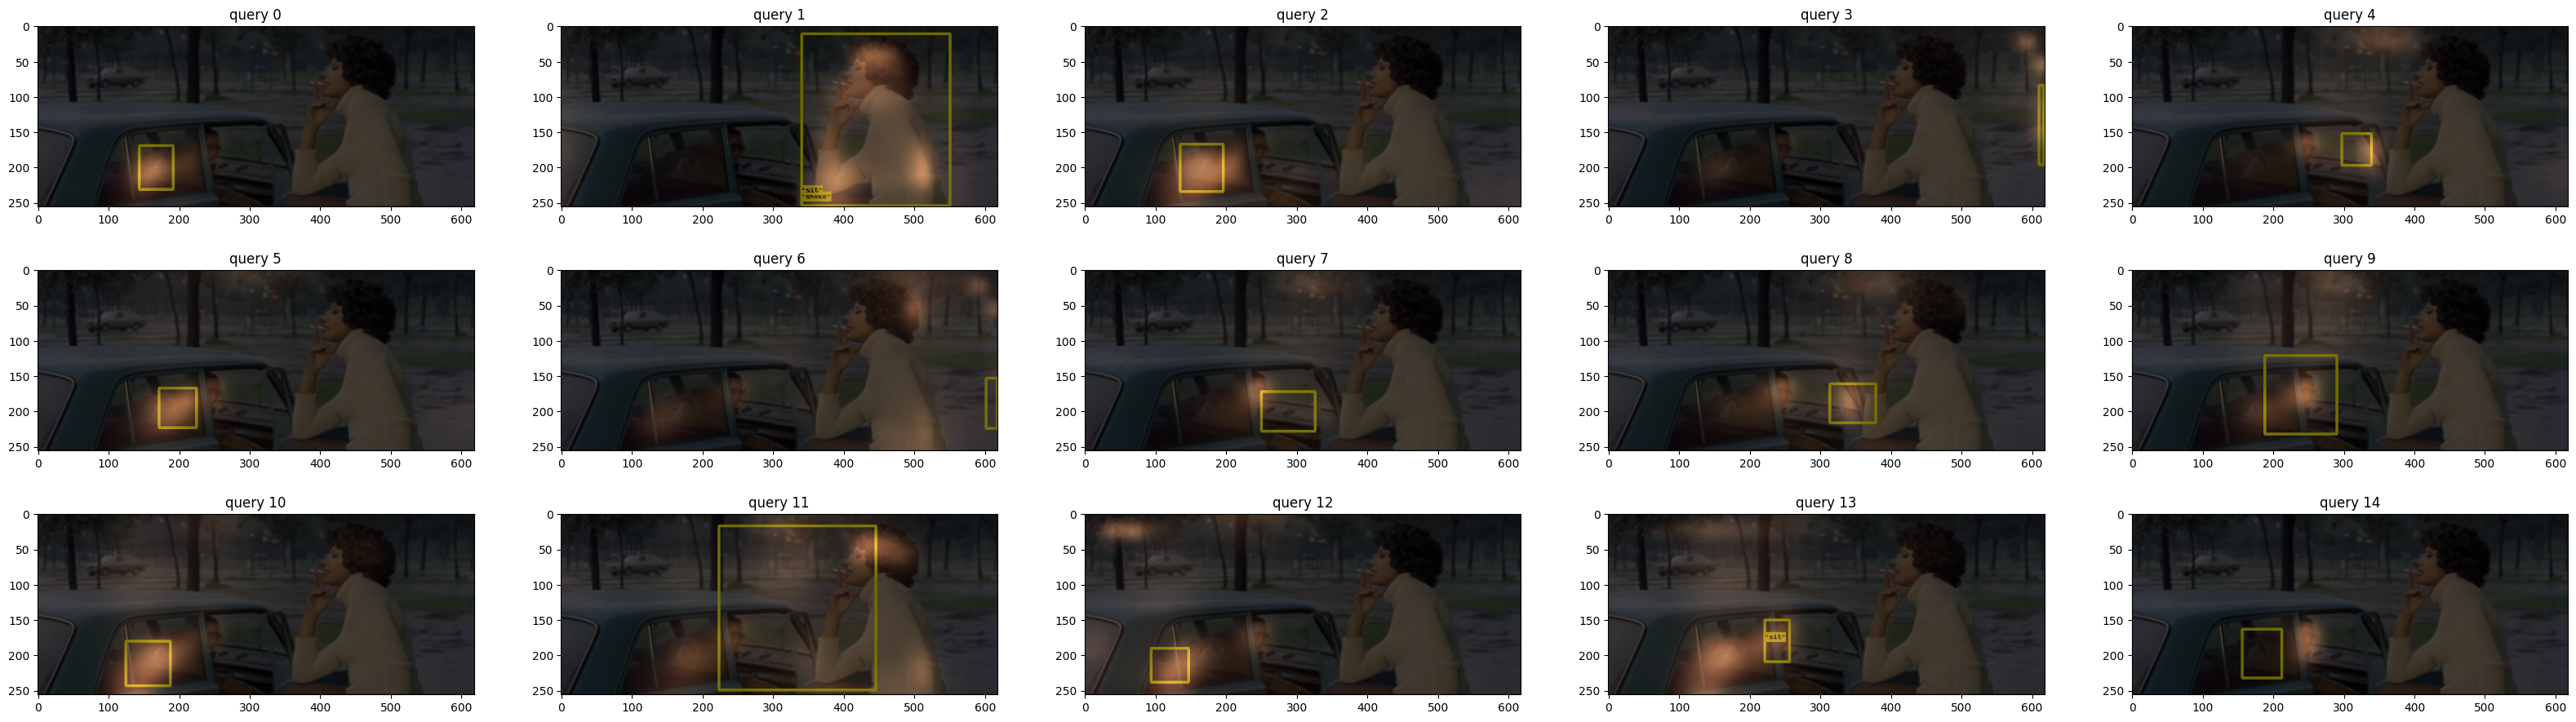

In [22]:
import copy
import visualization_utils_custom as vis_utils
%matplotlib inline

fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(40,11))
target_img = orig_vid[16]
for i, ax_i in enumerate(axs):
    for j in range(5):
        tgt_img = copy.deepcopy(target_img)
        coord = query_logits[i*5+j][:4]
        logits = query_logits[i*5+j][4:-1]
        bxmin, bymin, bxmax, bymax = coord[0], coord[1], coord[2], coord[3]
        cat = [items[i+1] for i, e in enumerate([k>0.7 for k in logits]) if e]
        vis_utils.draw_bounding_box_on_image(
            tgt_img, bymin, bxmin, bymax, bxmax,
                color = 'Yellow',
                display_str_list=cat,
                use_normalized_coordinates=False,
                margin2=30
            )
        ax_i[j].imshow(tgt_img)
        ax_i[j].imshow(dec_attn_weights[0, i*5+j].detach().cpu().view(h, w), cmap='copper', interpolation='bicubic', alpha=.6, extent=(xmin, xmax, ymin, ymax))
        ax_i[j].set_title("query {}".format(i*5+j))

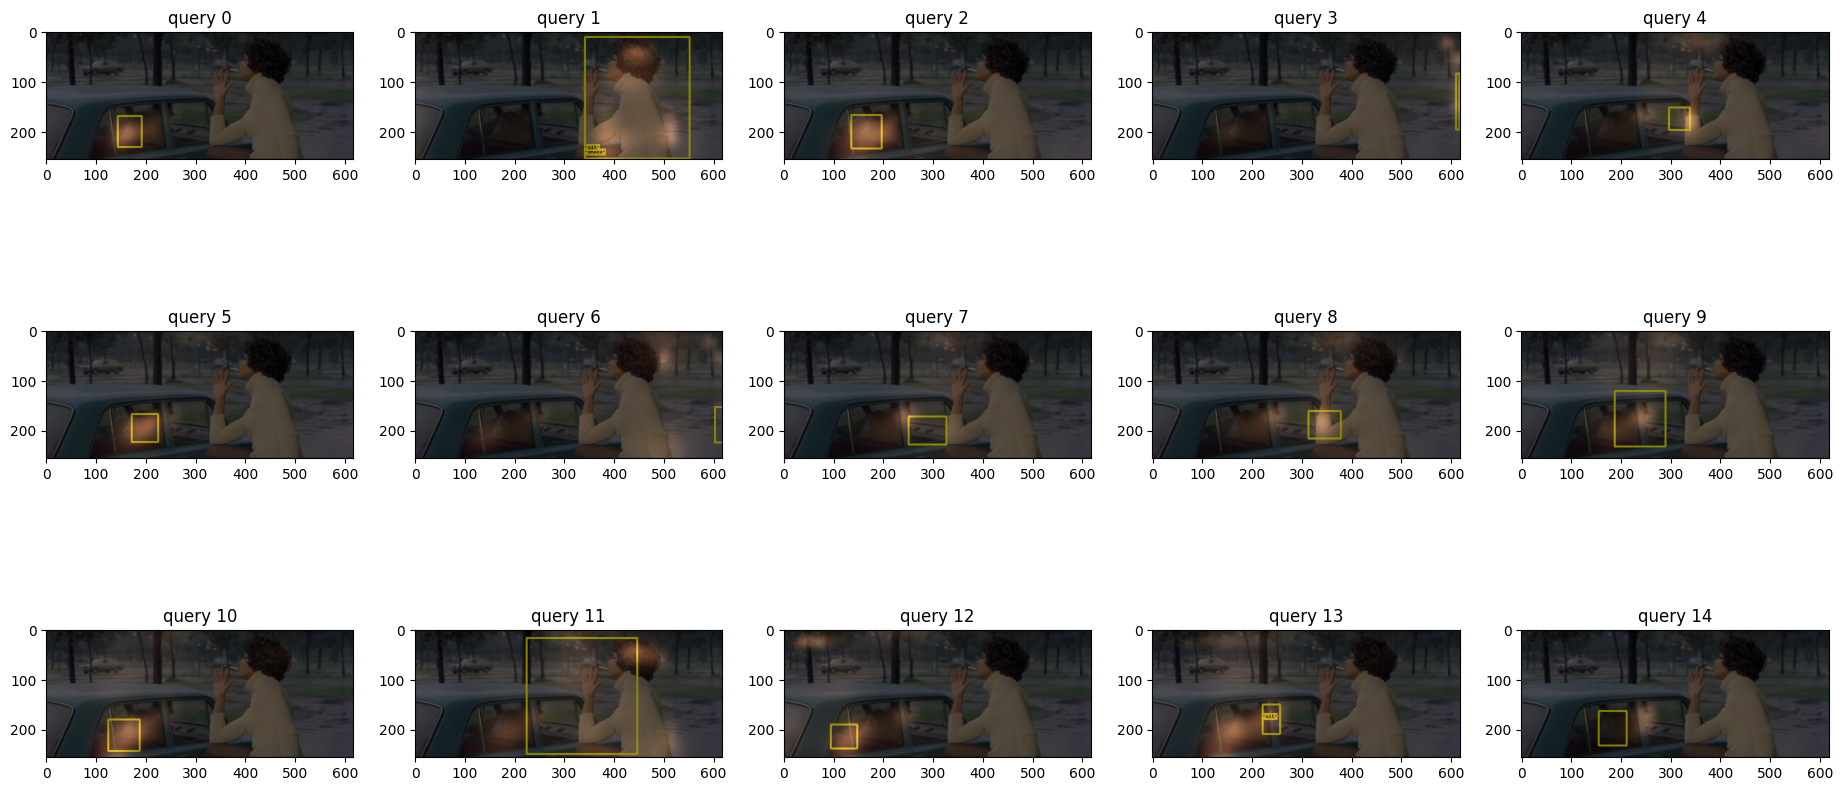

In [23]:
import copy
import visualization_utils_custom as vis_utils
%matplotlib inline

fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(23,11))
target_img = orig_vid[0]
for i, ax_i in enumerate(axs):
    for j in range(5):
        tgt_img = copy.deepcopy(target_img)
        coord = query_logits[i*5+j][:4]
        logits = query_logits[i*5+j][4:-1]
        bxmin, bymin, bxmax, bymax = coord[0], coord[1], coord[2], coord[3]
        cat = [items[i+1] for i, e in enumerate([k>0.7 for k in logits]) if e]
        vis_utils.draw_bounding_box_on_image(
            tgt_img, bymin, bxmin, bymax, bxmax,
                color = 'Yellow',
                display_str_list=cat,
                use_normalized_coordinates=False,
                margin2=30
            )
        ax_i[j].imshow(tgt_img)
        ax_i[j].imshow(dec_attn_weights[0, i*5+j].detach().cpu().view(h, w), cmap='copper', interpolation='bicubic', alpha=.5, extent=(xmin, xmax, ymin, ymax))
        ax_i[j].set_title("query {}".format(i*5+j))

In [ ]:
orig_vid[31]

In [ ]:
from utils.box_ops import box_cxcywh_to_xyxy
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b.cpu().detach().numpy()
    b = b * np.array([img_w, img_h, img_w, img_h], dtype=np.float32)
    return b
h, w = conv_features.shape[-2:]

probas = outputs['pred_logits'][0, :, :]
keep = probas > 0.7

# print(probas.shape)
# print(keep.shape)
# outputs['pred_boxes'][0, keep]
# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'], (h,w))

# print(outputs['pred_boxes'])
print(len(bboxes_scaled))

In [14]:
interested = [-3.99448299407959, 2.014373779296875, 84.5805435180664, 257.0118713378906, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7719477909849957e-05]